In [1]:
import sys
!{sys.executable} --version

import math
import numpy as np
from datetime import datetime
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.display import display
from math import log
from qpsolvers import solve_qp

%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Python 3.9.13


In [2]:
# https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average

companies, tickers = ['Honeywell','Salesforce'],['HON','CRM']
companies, tickers = ['Facebook','Amazon','Apple','Netflix','Google'],['FB','AMZN','AAPL','NFLX','GOOG']

DJ30 = pd.read_excel('DowJones30.xlsx',header=None)
tickers, companies = list(DJ30.iloc[:-1,0].values), list(DJ30.iloc[:-1,1].values) # exclude DOW 

tickers_df = yf.download(tickers, 
                      start='2017-01-01', 
                      end='2023-01-21', 
                      progress=False, auto_adjust=True)

returns = tickers_df['Close'].applymap(log).diff()[1:]

# annualize returns and covariance

stats = returns.agg(['mean', 'std', 'var'])
annual_returns = stats.transpose()['mean'] * 252
annual_covar = returns.cov() * 252

returns.columns

Index(['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS',
       'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK',
       'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT'],
      dtype='object')

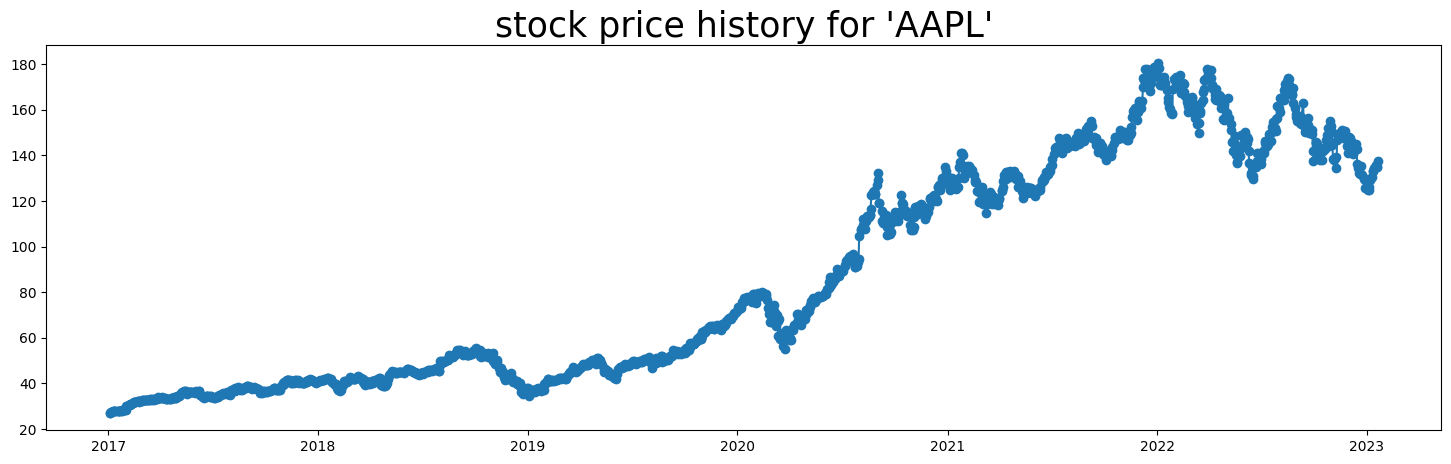

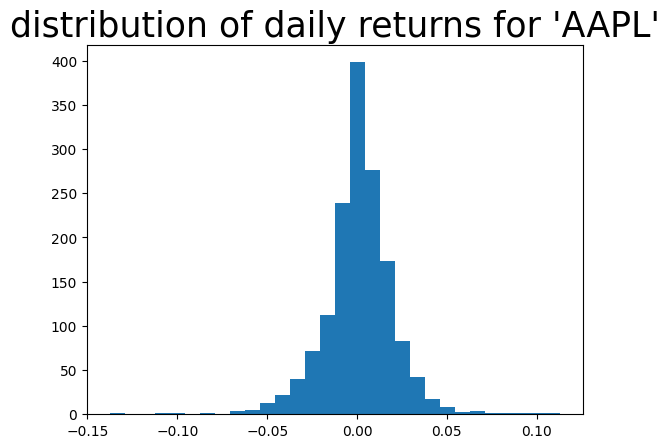

In [3]:
ticker = 'AAPL' # 'IBM' #
plt.figure(figsize=(18,5))

plt.plot(tickers_df[('Close',ticker)], 'o-')
plt.title(f"stock price history for '{ticker}'",fontsize=25)
plt.show()
plt.hist(returns[ticker],30)
plt.title(f"distribution of daily returns for '{ticker}'",fontsize=25)
plt.show()

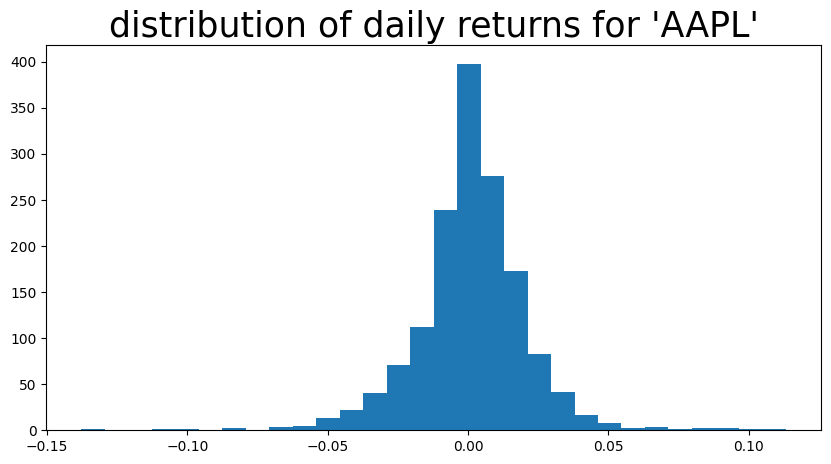

In [4]:
plt.figure(figsize=(10,5))

plt.hist(returns[ticker],30)
plt.title(f"distribution of daily returns for '{ticker}'",fontsize=25)
plt.show()

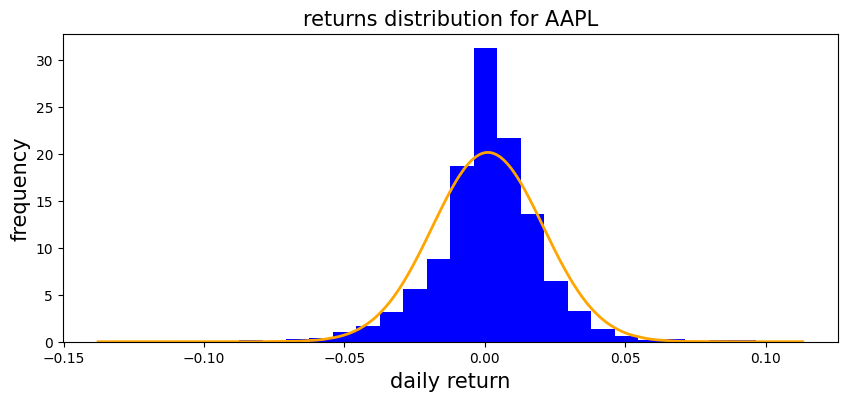

In [5]:
import numpy as np
import scipy.stats as stats
import pylab as pl

h = sorted(returns[ticker])
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  

pl.figure(figsize=(10,4))
pl.plot(h,fit,'-', color='orange', linewidth=2)
pl.hist(h,30 , density=True, color='blue')    
pl.title(f"returns distribution for {ticker}",fontsize=15)
pl.xlabel("daily return",fontsize=15)
pl.ylabel("frequency",fontsize=15)
pl.show()      

# Extreme Value Distribution
## generalized Pareto distribution

$G_{\xi,\beta}(y) = 1- \left[1+ \xi \frac{y}{\beta} \right]^{-\frac{1}{\xi}}$ if $\xi \neq 0$

$G_{\xi,\beta}(y) = 1- e^{-\frac{y}{\beta}}$ if $\xi = 0$

the density function is

$g_{\xi,\beta}(y) = \frac{\partial G_{\xi,\beta}}{\partial y}(y) =
\frac{1}{\beta} \left( 1 + \xi \frac{y}{\beta} \right)^{-\frac{1}{\xi} - 1}$

so the goal is to find values of $\mu, \beta, \xi$ to maximize the likelihood:

$\sum_{i=1}^{n_\mu} ln \left[ 
\frac{1}{\beta} \left( 1 + \xi \frac{v_i - \mu}{\beta} \right)^{-\frac{1}{\xi} - 1} 
\right ]$

where
$v_i$ are the $n_\mu$ observations in the right tail

In [6]:
from math import log

class EVT_distribution():
    """return the density and distribution functions for a Pareto distribution"""
    def __init__(self, x):
        self.xi = x[0]
        self.mu = x[1]
        self.beta = x[2]
        
    def density(self, v):
        return pow(1 + self.xi * (v - self.mu) / self.beta, -1 / self.xi - 1) / self.beta
    
    def distribution(self, v):
        if self.xi != 0:
            return 1 - pow(1 + self.xi * (v - self.mu) / self.beta, -1 / self.xi)
        else:
            return 1 - exp(-(v - self.mu) / self.beta)

class EVT_loglin():
    """return the log density and log likelihood functions for a Pareto distribution"""
    def __init__(self, vs):
        self.vs = vs    
        
    def log_likelihood(self, v):
        try:
            return \
        (-1 / self.xi - 1) * log(1 + self.xi * (v - self.mu) / self.beta) - log(self.beta)
        except:
            return 0      
    
    def log_likelihood_sum(self, x):
        self.xi = x[0]
        self.mu = x[1]
        self.beta = x[2]
        return sum([self.log_likelihood(-v) for v in self.vs])

    def negative_log_likelihood_sum(self, x):
        return -self.log_likelihood_sum(x)
    

# Fit a Pareto distribution to the left tail of returns
## loop through larger and larger sections of the tail
## determine when the coefficients stabilize

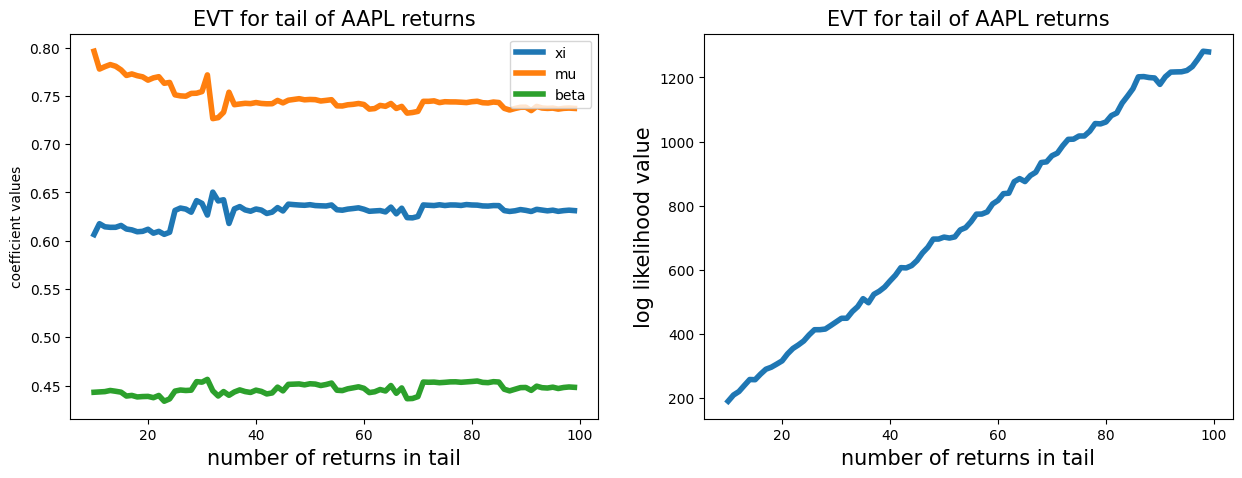

In [7]:
from scipy.optimize import minimize

def best_fit_EVT(tail_length):
    EVT = EVT_loglin(sorted_returns[:tail_length])
    x0 = np.array([0.6, 0.7, 0.5]) # np.random.rand(3)
    res = minimize(EVT.negative_log_likelihood_sum, x0, method='nelder-mead',
                   options={'xatol': 1e-8, 'disp': False})
    res_x = res.x
    return np.append(res_x, -res.fun)

sorted_returns = sorted(returns[ticker])
tail_sizes = np.arange(10,100,1)
ps = np.array([best_fit_EVT(s) for s in tail_sizes]).T  ####################

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for label,p in zip(["xi","mu","beta"], ps[:-1]):
    plt.plot(tail_sizes, p,label=label, linewidth=4)
plt.legend()
plt.title(f"EVT for tail of {ticker} returns",fontsize=15)
plt.xlabel("number of returns in tail",fontsize=15)
plt.ylabel("coefficient values")

plt.subplot(1,2,2)
plt.plot(tail_sizes, ps[-1],linewidth=4)
plt.title(f"EVT for tail of {ticker} returns",fontsize=15)
plt.xlabel("number of returns in tail",fontsize=15)
plt.ylabel("log likelihood value", fontsize=15)
plt.show()

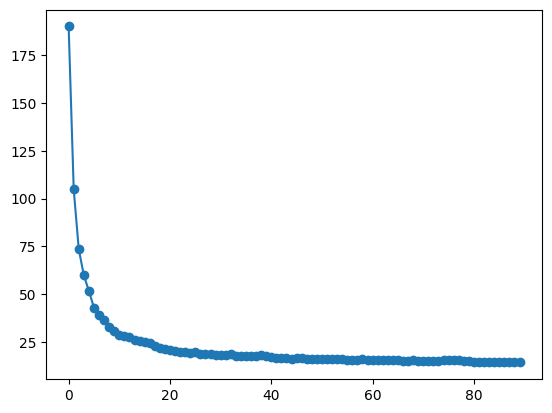

In [8]:
plt.plot(ps[-1] /np.arange(1,1+len(ps[-1])), 'o-')
plt.show()

# plot the tail and the parameterized Pareto distribution
## analytically fit the tail parameters for different tail samples

Fit the lowest 90 returns 5.91 % tail
xi = 0.6314, mu = 0.7383, beta = 0.4480


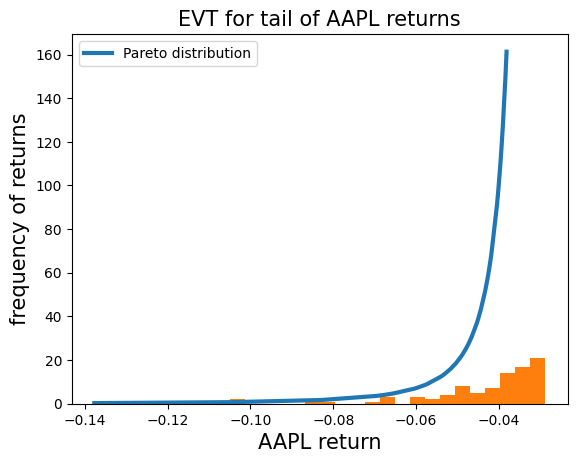

In [9]:
tail_length = 90
tail_returns = sorted_returns[:tail_length]

xi, mu, beta, _ = [p for t, p in zip(tail_sizes, ps.T) if t == tail_length][0]
print(f"Fit the lowest {tail_length} returns {tail_length/len(sorted_returns)*100:0.2f} % tail")
print(f"xi = {xi:0.4f}, mu = {mu:0.4f}, beta = {beta:0.4f}")

tail_model = EVT_distribution([xi, mu, beta])
EVT_tail = int(tail_length * .5)
plt.plot(tail_returns[:EVT_tail], 
         [tail_model.density(-v)/1000 for v in tail_returns[:EVT_tail]], 
         '-', linewidth=3,label="Pareto distribution")

plt.hist(tail_returns,30)
plt.legend()
plt.title(f"EVT for tail of {ticker} returns",fontsize=15)
plt.ylabel("frequency of returns", fontsize=15)
plt.xlabel(f"{ticker} return", fontsize=15)
plt.show()
         